<a href="https://colab.research.google.com/github/Pranu008/Big-Data-analytics-and-Machine-learning/blob/Neha-HC/Ridge_and_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importing numerical computing library for arrays and math operations
import numpy as np

# Importing pandas to load, clean and manipulate tabular datasets
import pandas as pd

# Importing subplots function to create figures and axes for visualizations
from matplotlib.pyplot import subplots

# Importing OLS (Ordinary Least Squares) regression model from statsmodels
from statsmodels.api import OLS

# Importing sklearn’s model_selection module for train/test split and CV tools
import sklearn.model_selection as skm

# Importing linear models such as Ridge, Lasso, ElasticNet
import sklearn.linear_model as skl

# Importing StandardScaler to normalize predictor variables before modeling
from sklearn.preprocessing import StandardScaler

# Importing dataset loader from ISLP (Introduction to Statistical Learning in Python)
from ISLP import load_data

# Importing ModelSpec to build design matrices similar to R's model.matrix
from ISLP.models import ModelSpec as MS

# Importing partial to pre-fill arguments in functions (used later for Cp)
from functools import partial


In [2]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=2f78dda8558edfa3b6148d029c0065fbe23602a2177f13bc1c183f35a14f7df1
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [4]:
# Importing Pipeline to chain preprocessing + model into one object
from sklearn.pipeline import Pipeline

# PCA for dimensionality reduction (not used heavily here, but imported)
from sklearn.decomposition import PCA

# PLS Regression (Partial Least Squares), another dimensionality technique
from sklearn.cross_decomposition import PLSRegression

# Importing stepwise selection utilities from ISLP
from ISLP.models import \
 (Stepwise,
  sklearn_selected,
  sklearn_selection_path)

# Installing l0bnb package for best-subset selection via L0-regularization
!pip install l0bnb

# After installation, import the fitting function
from l0bnb import fit_path


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22296 sha256=34317dc46e349cb191cce2e5e007fe0c1fd19c6f9fdacaa0fdd0f824a28fa3b9
  Stored in directory: /root/.cache/pip/wheels/0e/74/8b/8a39b657554150b98e1520971211118b5137e6a1873a85f66a
Successfully built l0bnb


In [5]:
# Load the Hitters dataset (baseball salary dataset)
Hitters = load_data('Hitters')

# Count how many missing values exist in the Salary column
np.isnan(Hitters['Salary']).sum()

# Drop rows with missing Salary values (because regression cannot use NaN target values)
Hitters = Hitters.dropna()

# Display new dataset shape after removing missing data
Hitters.shape


(263, 20)

In [6]:
# Define a function to compute negative Mallows Cp statistic
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"

    # Extract number of samples (n) and number of predictors (p)
    n, p = X.shape

    # Predict Y using the estimator passed into the function
    Yhat = estimator.predict(X)

    # Compute residual sum of squares (RSS)
    RSS = np.sum((Y - Yhat)**2)

    # Compute and return negative Cp
    # Negative is used since sklearn_selected tries to maximize the scoring function
    return -(RSS + 2 * p * sigma2) / n


In [7]:
# Build a ModelSpec object using all predictors except Salary (target variable)
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)

# Extract target variable as numpy array
Y = np.array(Hitters['Salary'])

# Convert predictors into numeric design matrix
X = design.transform(Hitters)

# Compute sigma² (residual variance) using full OLS model
sigma2 = OLS(Y, X).fit().scale

# Create neg_Cp by pre-filling sigma2 into the Cp function
neg_Cp = partial(nCp, sigma2)


In [8]:
# Create a forward stepwise strategy that stops when validation peaks
strategy = Stepwise.first_peak(
    design,
    direction='forward',
    max_terms=len(design.terms)
)

# Run stepwise selection using default criterion (MSE)
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)

# Show which model was selected using in-sample MSE
hitters_MSE.selected_state_

# Run stepwise selection using Cp statistic instead of MSE
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)

# Show selected model using Cp
hitters_Cp.selected_state_


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

(50000.0, 250000.0)

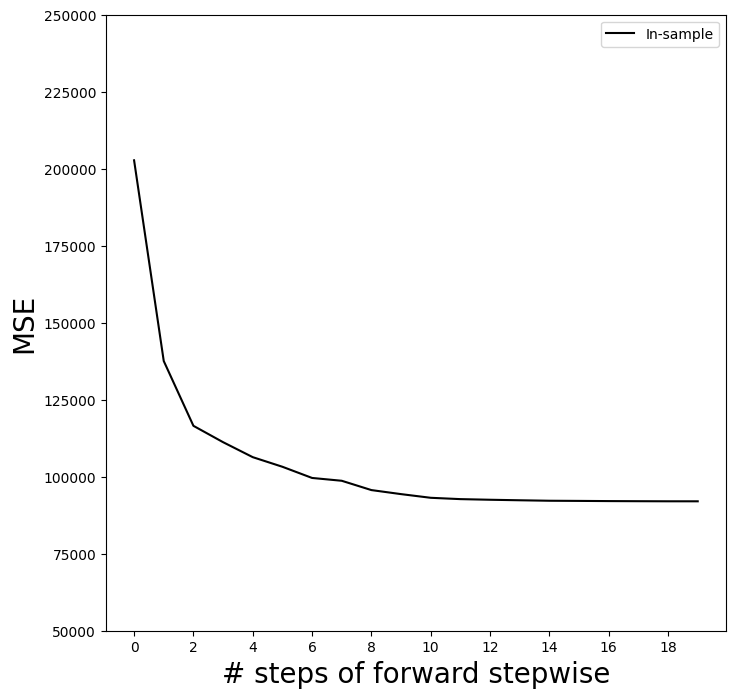

In [9]:
# Create a forward stepwise strategy that adds variables one step at a time
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

# Fit a path of OLS models of increasing size
full_path = sklearn_selection_path(OLS, strategy)
full_path.fit(Hitters, Y)

# Predict values for all models in the stepwise path
Yhat_in = full_path.predict(Hitters)

# Plot setup
mse_fig, ax = subplots(figsize=(8,8))

# Compute in-sample MSE for each model size
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]

# Plot in-sample MSE across steps
ax.plot(
    np.arange(n_steps),
    insample_mse,
    'k',
    label='In-sample'
)

# Label axes and formatting
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])


In [10]:
# Setup 5-fold cross-validation
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

# Generate CV predictions for every model in the path
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)

# Compute CV MSE for each fold and each model
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    # Compute squared errors for the test fold
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2

    # Record mean error for each model
    cv_mse.append(errors.mean(0))

# Convert results into (steps × folds) matrix
cv_mse = np.array(cv_mse).T

# Overlay CV MSE with error bars on the plot
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(1),
    cv_mse.std(1) / np.sqrt(K),
    label='Cross-validated',
    c='r'
)

ax.set_ylim([50000,250000])
ax.legend()


In [11]:
# Create a validation split with 20% as testing data
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=0
)

# Fit full path on training subset only
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])

# Predict on validation subset
Yhat_val = full_path.predict(Hitters.iloc[test_idx])

# Compute validation MSE for each model
errors = (Yhat_val - Y[test_idx, None])**2
validation_mse = errors.mean(0)

# Add validation MSE line to the existing plot
ax.plot(
    np.arange(n_steps),
    validation_mse,
    'b--',
    label='Validation'
)

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()


In [13]:
import numpy as np
np.Inf = np.inf      # Patch deprecated attribute for old libraries

# Build design matrix and remove intercept (l0bnb expects no intercept column)
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)

# Convert to numpy
X = np.asarray(D)

# Fit full L0 regularization path: model sizes from 1 to p predictors
path = fit_path(
    X,
    Y,
    max_nonzeros=X.shape[1]
)

# View model of size 3
path[3]


Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': np.float64(-38.98216739555505),
 'lambda_0': np.float64(0.011416248027450187),
 'M': np.float64(0.5829861733382012),
 'Time_exceeded': False}

In [14]:
# Standardize X manually
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]

# Create lambda (α) sequence: wide range from 1e8 to 1e-2
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# Compute ridge regression path using ElasticNet with l1_ratio = 0
soln_array = skl.ElasticNet.path(
    Xs,
    Y,
    l1_ratio=0.,
    alphas=lambdas
)[1]

# Store path results in a DataFrame
soln_path = pd.DataFrame(
    soln_array.T,
    columns=D.columns,
    index=-np.log(lambdas)
)

# Name index as negative log(lambda)
soln_path.index.name = 'negative log(lambda)'


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did n

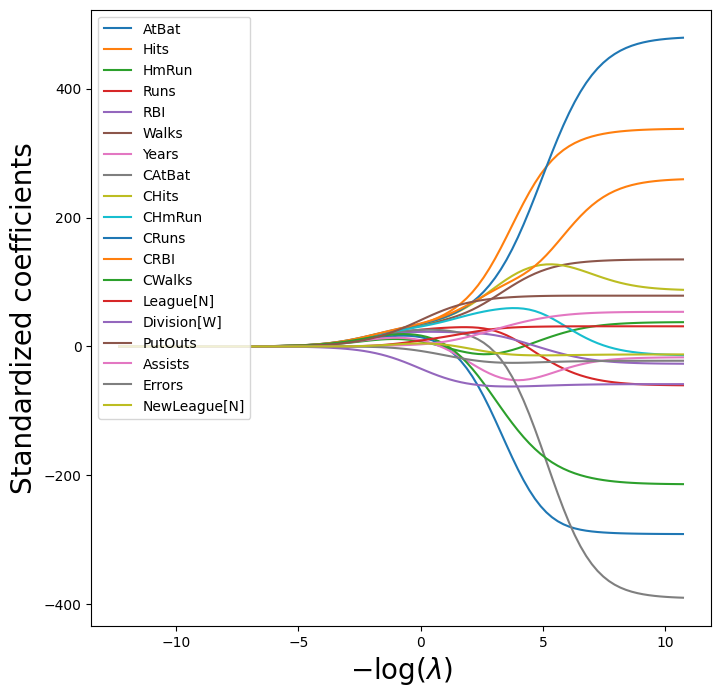

In [15]:
# Create plot for ridge coefficient paths
path_fig, ax = subplots(figsize=(8, 8))

# Plot path without legend clutter
soln_path.plot(ax=ax, legend=False)

# Label axes
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

# Add small legend at top-left
ax.legend(loc='upper left')
